In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
from IPython.display import clear_output

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 4)

### MNIST Digit Classification

In [2]:
# Download and splitting MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

100%|██████████| 9.91M/9.91M [00:02<00:00, 3.93MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.70MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.57MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.71MB/s]

Training samples: 60000
Test samples: 10000


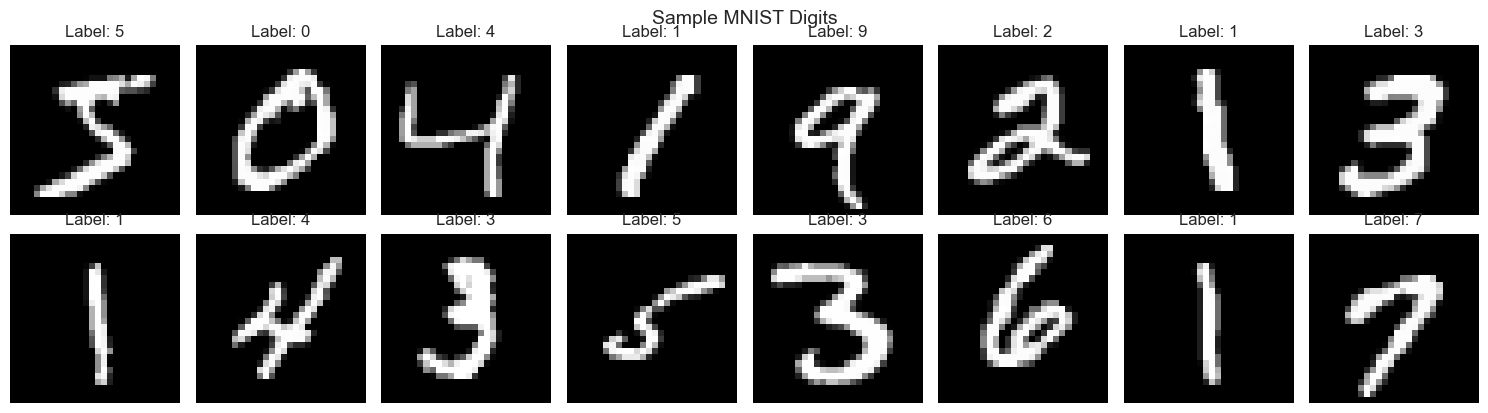

In [3]:
# MNIST samples
fig, axes = plt.subplots(2, 8, figsize=(15, 4))
for i, ax in enumerate(axes.flat):
    image, label = train_dataset[i]
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')
plt.tight_layout()
plt.suptitle('Sample MNIST Digits', y=1.02, fontsize=14)
plt.show()

In [5]:
#CNN architecture for MNIST classification
class MNISTNet(nn.Module):
    """Neural network for MNIST classification."""
    
    def __init__(self, hidden_sizes, activation='relu', dropout=0.0):
        super(MNISTNet, self).__init__()
        
        layers = []
        prev_size = 784  # 28x28 flattened
        
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'tanh':
                layers.append(nn.Tanh())
            elif activation == 'sigmoid':
                layers.append(nn.Sigmoid())
            
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            
            prev_size = hidden_size
        
        layers.append(nn.Linear(prev_size, 10))  # 10 output classes
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the image
        return self.network(x)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters())


def train_mnist(model, train_loader, test_loader, epochs=10, lr=0.01, device='cpu'):
    """Train MNIST classifier and track metrics."""
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    train_accs = []
    test_accs = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        avg_loss = total_loss / len(train_loader)
        train_acc = 100 * correct / total
        
        # Testing
        test_acc = evaluate_mnist(model, test_loader, device)
        
        train_losses.append(avg_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        
        print(f'Epoch [{epoch+1}/{epochs}] '
              f'Loss: {avg_loss:.4f} '
              f'Train Acc: {train_acc:.2f}% '
              f'Test Acc: {test_acc:.2f}%')
    
    return train_losses, train_accs, test_accs


def evaluate_mnist(model, test_loader, device='cpu'):
    """Evaluate model on test set."""
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return 100 * correct / total

In [6]:
#2 Layer 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Simple baseline model
model_baseline = MNISTNet(hidden_sizes=[128], activation='relu')
print(f"\nBaseline Model Parameters: {model_baseline.count_parameters():,}")

train_losses, train_accs, test_accs = train_mnist(
    model_baseline, train_loader, test_loader, 
    epochs=10, lr=0.001, device=device
)

Using device: cpu

Baseline Model Parameters: 101,770
Epoch [1/10] Loss: 0.2582 Train Acc: 92.42% Test Acc: 95.77%
Epoch [2/10] Loss: 0.1126 Train Acc: 96.64% Test Acc: 96.90%
Epoch [3/10] Loss: 0.0778 Train Acc: 97.63% Test Acc: 96.86%
Epoch [4/10] Loss: 0.0608 Train Acc: 98.05% Test Acc: 97.70%
Epoch [5/10] Loss: 0.0462 Train Acc: 98.52% Test Acc: 97.68%
Epoch [6/10] Loss: 0.0377 Train Acc: 98.80% Test Acc: 97.57%
Epoch [7/10] Loss: 0.0308 Train Acc: 98.96% Test Acc: 97.52%
Epoch [8/10] Loss: 0.0259 Train Acc: 99.15% Test Acc: 97.33%
Epoch [9/10] Loss: 0.0212 Train Acc: 99.27% Test Acc: 97.88%
Epoch [10/10] Loss: 0.0183 Train Acc: 99.41% Test Acc: 98.01%


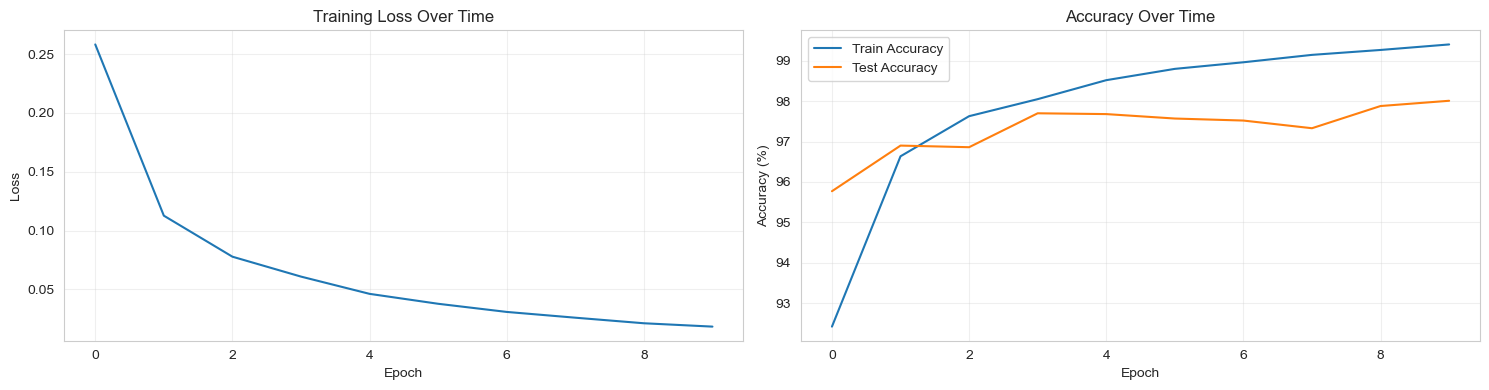

In [7]:
# Visualize training progress
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

ax1.plot(train_losses)
ax1.set_title('Training Loss Over Time')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True, alpha=0.3)

ax2.plot(train_accs, label='Train Accuracy')
ax2.plot(test_accs, label='Test Accuracy')
ax2.set_title('Accuracy Over Time')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [9]:
architectures_mnist = [
    ([128], "1 Hidden Layer"),
    ([256, 128], "2 Hidden Layers"),
    ([512, 256, 128], "3 Hidden Layers"),
]

results = {}

for hidden_sizes, label in architectures_mnist:
    print(f"Training: {label}")

    model = MNISTNet(hidden_sizes=hidden_sizes, activation='relu')
    print(f"Parameters: {model.count_parameters():,}")
    
    train_losses, train_accs, test_accs = train_mnist(
        model, train_loader, test_loader, 
        epochs=10, lr=0.001, device=device
    )
    
    results[label] = {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_accs': test_accs,
        'params': model.count_parameters()
    }

Training: 1 Hidden Layer
Parameters: 101,770
Epoch [1/10] Loss: 0.2575 Train Acc: 92.43% Test Acc: 95.90%
Epoch [2/10] Loss: 0.1121 Train Acc: 96.63% Test Acc: 96.60%
Epoch [3/10] Loss: 0.0771 Train Acc: 97.65% Test Acc: 97.05%
Epoch [4/10] Loss: 0.0576 Train Acc: 98.26% Test Acc: 97.47%
Epoch [5/10] Loss: 0.0452 Train Acc: 98.52% Test Acc: 97.64%
Epoch [6/10] Loss: 0.0364 Train Acc: 98.81% Test Acc: 97.46%
Epoch [7/10] Loss: 0.0304 Train Acc: 99.02% Test Acc: 97.20%
Epoch [8/10] Loss: 0.0254 Train Acc: 99.16% Test Acc: 97.67%
Epoch [9/10] Loss: 0.0235 Train Acc: 99.24% Test Acc: 97.66%
Epoch [10/10] Loss: 0.0198 Train Acc: 99.34% Test Acc: 97.66%
Training: 2 Hidden Layers
Parameters: 235,146
Epoch [1/10] Loss: 0.2281 Train Acc: 93.07% Test Acc: 96.52%
Epoch [2/10] Loss: 0.0915 Train Acc: 97.18% Test Acc: 97.09%
Epoch [3/10] Loss: 0.0661 Train Acc: 97.86% Test Acc: 97.56%
Epoch [4/10] Loss: 0.0495 Train Acc: 98.39% Test Acc: 97.01%
Epoch [5/10] Loss: 0.0376 Train Acc: 98.75% Test Acc: 

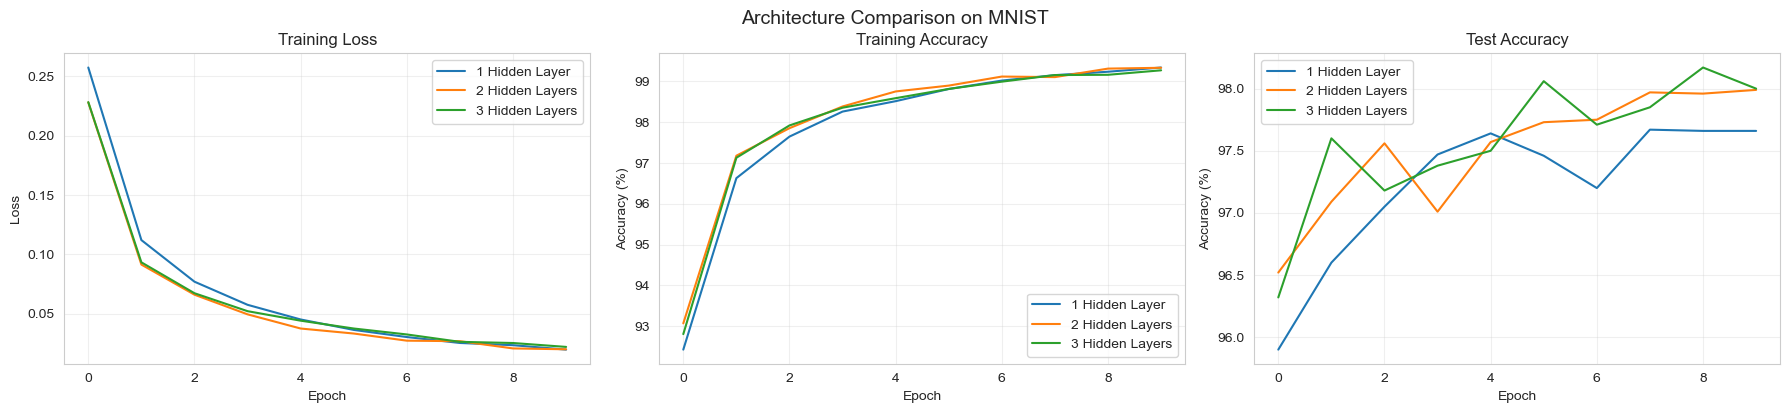


Final Test Accuracies:
1 Hidden Layer: 97.66% (Params: 101,770)
2 Hidden Layers: 97.99% (Params: 235,146)
3 Hidden Layers: 98.00% (Params: 567,434)


In [10]:
# plots to compare architectures
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

for label, data in results.items():
    axes[0].plot(data['train_losses'], label=label)
    axes[1].plot(data['train_accs'], label=label)
    axes[2].plot(data['test_accs'], label=label)

axes[0].set_title('Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].set_title('Training Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].set_title('Test Accuracy')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Accuracy (%)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Architecture Comparison on MNIST', y=1.02, fontsize=14)
plt.show()

# Print final results
print("\nFinal Test Accuracies:")
for label, data in results.items():
    print(f"{label}: {data['test_accs'][-1]:.2f}% (Params: {data['params']:,})")

In [11]:
#Testing various activation functions
activations = ['relu', 'tanh', 'sigmoid']
activation_results = {}

for activation in activations:
    print(f"Training with {activation.upper()} activation")
    
    model = MNISTNet(hidden_sizes=[256, 128], activation=activation)
    
    train_losses, train_accs, test_accs = train_mnist(
        model, train_loader, test_loader, 
        epochs=10, lr=0.001, device=device
    )
    
    activation_results[activation] = {
        'train_losses': train_losses,
        'test_accs': test_accs
    }

Training with RELU activation
Epoch [1/10] Loss: 0.2278 Train Acc: 93.15% Test Acc: 96.54%
Epoch [2/10] Loss: 0.0959 Train Acc: 97.04% Test Acc: 97.08%
Epoch [3/10] Loss: 0.0656 Train Acc: 97.95% Test Acc: 97.40%
Epoch [4/10] Loss: 0.0513 Train Acc: 98.37% Test Acc: 97.49%
Epoch [5/10] Loss: 0.0405 Train Acc: 98.69% Test Acc: 97.81%
Epoch [6/10] Loss: 0.0331 Train Acc: 98.94% Test Acc: 97.56%
Epoch [7/10] Loss: 0.0287 Train Acc: 99.00% Test Acc: 98.03%
Epoch [8/10] Loss: 0.0247 Train Acc: 99.19% Test Acc: 98.09%
Epoch [9/10] Loss: 0.0236 Train Acc: 99.22% Test Acc: 98.29%
Epoch [10/10] Loss: 0.0197 Train Acc: 99.35% Test Acc: 97.98%
Training with TANH activation
Epoch [1/10] Loss: 0.2327 Train Acc: 93.13% Test Acc: 95.98%
Epoch [2/10] Loss: 0.0989 Train Acc: 96.95% Test Acc: 97.03%
Epoch [3/10] Loss: 0.0692 Train Acc: 97.86% Test Acc: 97.14%
Epoch [4/10] Loss: 0.0545 Train Acc: 98.29% Test Acc: 97.34%
Epoch [5/10] Loss: 0.0446 Train Acc: 98.56% Test Acc: 97.31%
Epoch [6/10] Loss: 0.040

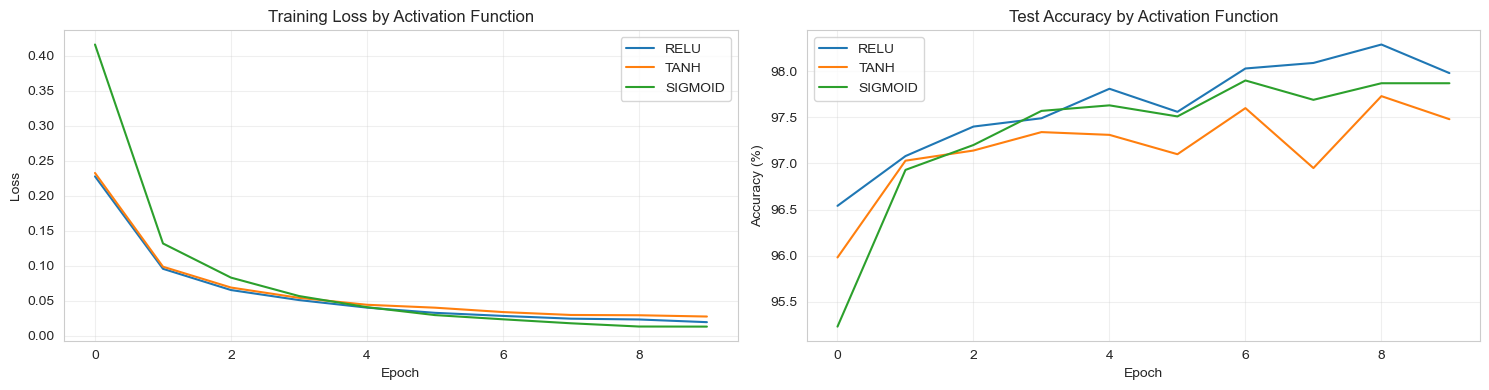


Final Test Accuracies:
RELU: 97.98%
TANH: 97.48%
SIGMOID: 97.87%


In [12]:
# plot to compare activation functions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

for activation, data in activation_results.items():
    ax1.plot(data['train_losses'], label=activation.upper())
    ax2.plot(data['test_accs'], label=activation.upper())

ax1.set_title('Training Loss by Activation Function')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.set_title('Test Accuracy by Activation Function')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nFinal Test Accuracies:")
for activation, data in activation_results.items():
    print(f"{activation.upper()}: {data['test_accs'][-1]:.2f}%")

In [13]:
#Comparing different learning rates
learning_rates = [0.1, 0.01, 0.001]
lr_results = {}

for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    
    model = MNISTNet(hidden_sizes=[256, 128], activation='relu')
    
    train_losses, train_accs, test_accs = train_mnist(
        model, train_loader, test_loader, 
        epochs=10, lr=lr, device=device
    )
    
    lr_results[lr] = {
        'train_losses': train_losses,
        'test_accs': test_accs
    }

Training with learning rate: 0.1
Epoch [1/10] Loss: 3.2828 Train Acc: 20.41% Test Acc: 20.68%
Epoch [2/10] Loss: 2.0184 Train Acc: 20.40% Test Acc: 20.60%
Epoch [3/10] Loss: 2.3387 Train Acc: 12.17% Test Acc: 8.92%
Epoch [4/10] Loss: 2.3108 Train Acc: 10.36% Test Acc: 10.28%
Epoch [5/10] Loss: 2.3100 Train Acc: 10.52% Test Acc: 10.09%
Epoch [6/10] Loss: 2.3097 Train Acc: 10.30% Test Acc: 10.32%
Epoch [7/10] Loss: 2.3100 Train Acc: 10.21% Test Acc: 10.10%
Epoch [8/10] Loss: 2.3095 Train Acc: 10.43% Test Acc: 11.35%
Epoch [9/10] Loss: 2.3098 Train Acc: 10.34% Test Acc: 9.80%
Epoch [10/10] Loss: 2.3103 Train Acc: 10.30% Test Acc: 11.35%
Training with learning rate: 0.01
Epoch [1/10] Loss: 0.2948 Train Acc: 91.44% Test Acc: 94.31%
Epoch [2/10] Loss: 0.2010 Train Acc: 94.67% Test Acc: 95.13%
Epoch [3/10] Loss: 0.1799 Train Acc: 95.24% Test Acc: 95.46%
Epoch [4/10] Loss: 0.1737 Train Acc: 95.52% Test Acc: 95.48%
Epoch [5/10] Loss: 0.1556 Train Acc: 96.03% Test Acc: 95.70%
Epoch [6/10] Loss: 

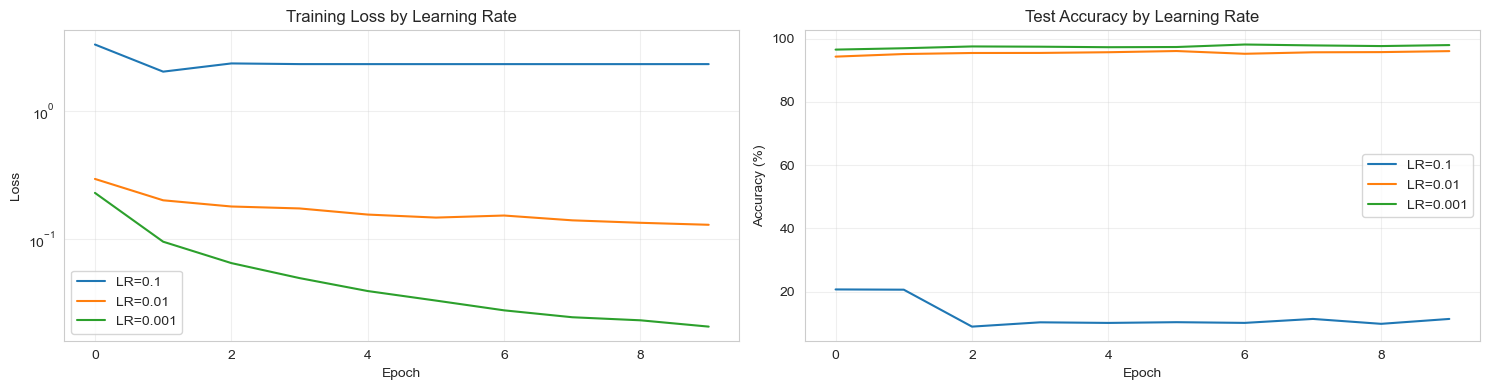


Final Test Accuracies:
LR=0.1: 11.35%
LR=0.01: 96.05%
LR=0.001: 97.96%


In [14]:
#plot to compare learning rates
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

for lr, data in lr_results.items():
    ax1.plot(data['train_losses'], label=f'LR={lr}')
    ax2.plot(data['test_accs'], label=f'LR={lr}')

ax1.set_title('Training Loss by Learning Rate')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_yscale('log')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.set_title('Test Accuracy by Learning Rate')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nFinal Test Accuracies:")
for lr, data in lr_results.items():
    print(f"LR={lr}: {data['test_accs'][-1]:.2f}%")

Learning Rate


From the learning rate experiments, we see that using a high learning rate (0.1) causes the neural network to become unstable and fail to converge, as the parameter updates overshoot the optimal solution. 

The ideal learning rate here is 0.001 and it doesn't overshoot the optimal solution and converges uniformally 

Layers

Adding layers increases the overall power of the neural network, which makes it model more complex patterns, but can also makes optimization harder and increases the chance of overfitting risk. In the MNIST case, the problem is simple enough where we don't see a noticable difference for various layers.

Activation layers

Changing the activation function changes how the network transforms information, which affects how easily it learns, how fast it trains, and how well it performs.
In the case of the MNIST dataset, we don't see a noticable difference between using different activation function.